In [298]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.api import SARIMAX
from statsmodels.tsa.deterministic import DeterministicProcess
import matplotlib.pyplot as plt
import numpy as np
import pandas_datareader as pdr
import seaborn as sns
from statsmodels.tsa.api import acf, graphics, pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.stattools import adfuller,kpss
import warnings
warnings.simplefilter(action='ignore')

In [299]:
from matplotlib.pylab import rcParams

In [300]:
rcParams['figure.figsize'] = 15,6

In [301]:
#testes para checar estacionaridade e converter em estacionari
#https://www.statsmodels.org/devel/examples/notebooks/generated/stationarity_detrending_adf_kpss.html#ADF-test

In [302]:
dados = pd.read_excel(r"C:\testeseries_temprais\VendaComunicacao.xlsx")

dados.sort_values('dataCadastro',ascending=False)
dados = dados[dados['pedidoShowroom'] == 0]


In [304]:
dados.columns

Index(['id', 'vendaId', 'fabricanteId', 'observacoes', 'dataCadastro',
       'statusId', 'formaPagamento', 'faturamento', 'totalPedido',
       'dataLimite', 'valorFinalPedido', 'codigoRef', 'pedidoShowroom',
       'transportadoraId', 'descritivoPlanejados', 'dataLimiteProducao',
       'dataEstimadaCliente', 'valorFrete', 'dataPrevisaoEntrega',
       'pontoAtencao', 'dataEfetivaEntrega', 'Unnamed: 21', 'Unnamed: 22',
       'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26',
       'Unnamed: 27', 'Unnamed: 28', 'Unnamed: 29', 'Unnamed: 30'],
      dtype='object')

In [305]:
dados['pedidoShowroom'].head(3)

0    0
1    0
2    0
Name: pedidoShowroom, dtype: object

In [306]:
vendas = dados[['dataCadastro','totalPedido']]
vendas.dropna(inplace=True)

vendas['dataCadastro'] = vendas['dataCadastro'].apply(lambda x: pd.Timestamp(x).strftime('%Y-%m-%d'))

vendas['totalPedido'] = vendas['totalPedido'].astype(float)

In [307]:
vendas

,dataCadastro,totalPedido
0,2021-03-04,387.85
1,2021-04-28,3581.88
2,2021-04-28,515.33
3,2021-05-04,488.62
4,2021-06-07,912.60
...,...,...
16381,2023-03-09,3946.33
16382,2023-03-09,1948.63
16383,2023-03-09,3946.33
16384,2023-03-09,1948.63


In [308]:
vendas = vendas.groupby('dataCadastro')['totalPedido'].sum().reset_index()
vendas.drop_duplicates(subset="dataCadastro", keep='first')
vendas.set_index('dataCadastro',inplace=True)

vendas

,totalPedido
dataCadastro,
2021-03-04,387.85
2021-04-28,4097.21
2021-05-04,488.62
2021-06-07,912.60
2021-06-09,515.33
...,...
2023-03-05,0.00
2023-03-06,6678.12
2023-03-07,0.00


<Axes: xlabel='dataCadastro'>

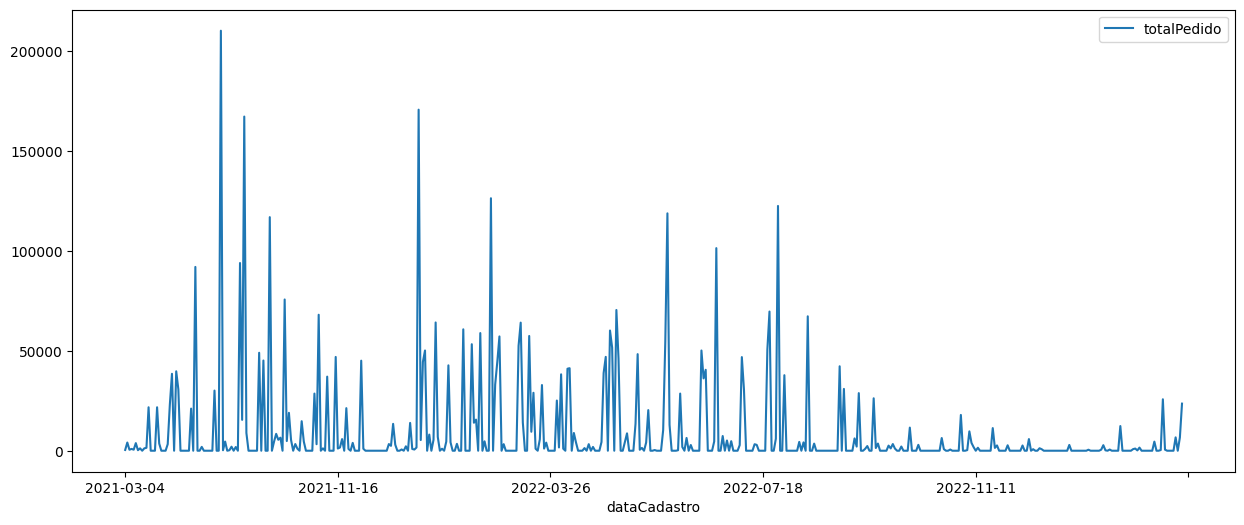

In [309]:
vendas.plot()

In [310]:
#Hipótese Nula: A série tem raiz unitária.

#Hipótese alternativa: A série não tem raiz unitária.

#Se a hipótese nula não for rejeitada, este teste pode fornecer evidências de que a série é não estacionária.

In [311]:
def adf_test(timeseries):
    print("Resultados do Teste de Dickey-Fuller:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "estatistica de teste",
            "Valor - P",
            "#Lags usados",
            "Número de observações usadas",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Valor crítico (%s)" % key] = value
    print(dfoutput)


adf_test(vendas)

Results of Dickey-Fuller Test:
Test Statistic                  -4.464587
p-value                          0.000228
#Lags Used                      11.000000
Number of Observations Used    486.000000
Critical Value (1%)             -3.443877
Critical Value (5%)             -2.867505
Critical Value (10%)            -2.569947
dtype: float64


In [312]:
def kpss_test(timeseries):
    print("Resultados do teste KPSS:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["estatistica de teste", "Valor - P", "#Lags usados"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Valor crítico (%s)" % key] = value
    print(kpss_output)

kpss_test(vendas)

Results of KPSS Test:
Test Statistic           1.622505
p-value                  0.010000
Lags Used                5.000000
Critical Value (10%)     0.347000
Critical Value (5%)      0.463000
Critical Value (2.5%)    0.574000
Critical Value (1%)      0.739000
dtype: float64


<Axes: xlabel='dataCadastro'>

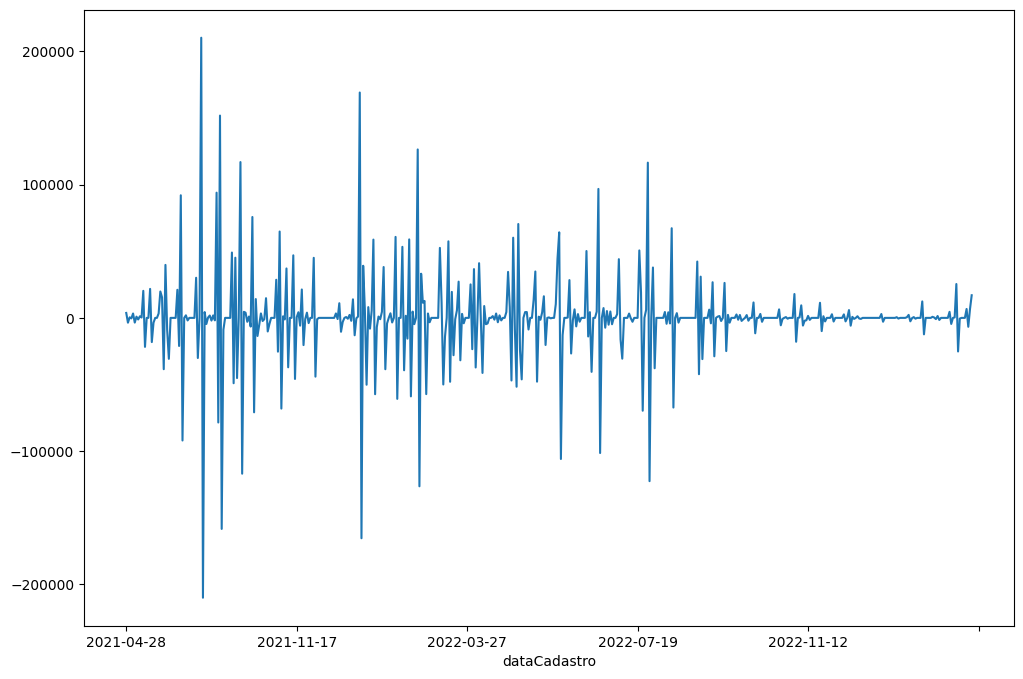

In [313]:
vendas["totalPedido_diff"] = vendas["totalPedido"] - vendas["totalPedido"].shift(
    1
)
vendas["totalPedido_diff"].dropna().plot(figsize=(12, 8))


In [314]:
adf_test(vendas["totalPedido_diff"].dropna())


Results of Dickey-Fuller Test:
Test Statistic                -1.164106e+01
p-value                        2.146386e-21
#Lags Used                     1.200000e+01
Number of Observations Used    4.840000e+02
Critical Value (1%)           -3.443933e+00
Critical Value (5%)           -2.867530e+00
Critical Value (10%)          -2.569961e+00
dtype: float64


In [315]:
kpss_test(vendas["totalPedido_diff"].dropna())


Results of KPSS Test:
Test Statistic            0.097942
p-value                   0.100000
Lags Used                83.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
